In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from cStringIO import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time
import os.path
from os import path


In [2]:
from scipy.integrate import romb

def integrate2DGrid(g, dx, dy):
    if g.shape[0]%2 == 0 or g.shape[1]%2 == 0:
        raise ValueError('integrate2DGrid requires a grid with odd number of points on a side');
    return romb(romb(g, dx), dy)

def integrateRateModel(periodRange, rpRange, theta, model):
    nPts = 2**5+1 # must be 2**n + 1
    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nPts), 
                                       np.linspace(rpRange[0], rpRange[1], nPts), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    
    if theta.ndim == 1:
        y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)
        return integrate2DGrid(y, dp, dr)
    else: # assume first dimension is array of thetas
        ret = np.zeros(theta.shape[0])
        if len(ret) > 100:
            f = FloatProgress(min=0, max=len(ret))
            display(f)

        for i in range(len(ret)):
            y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta[i,:], model)
            ret[i] = integrate2DGrid(y, dp, dr)
            if len(ret) > 100:
                f.value += 1
        return ret


def integratePopTimesComp(periodRange, rpRange, theta, model, compGrid):
    nP = compGrid.shape[0]
    nR = compGrid.shape[1]

    pGrid, rGrid = np.meshgrid(np.linspace(periodRange[0], periodRange[1], nP), 
                                       np.linspace(rpRange[0], rpRange[1], nR), 
                                       indexing="ij")
    dp = (pGrid[1,0]-pGrid[0,0])
    dr = (rGrid[0,1]-rGrid[0,0])
    y = rateModel(pGrid, rGrid, period_rng, rp_rng, theta, model)*compGrid
    return integrate2DGrid(y, dp, dr)



In [3]:

def rateModel(x, y, xRange, yRange, theta, model):
    if model == "dualPowerLaw":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1))
    elif model == "dualPowerLawGap":
        f0, alpha, beta, gd, gw, gapOffset, gapSlope = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
#        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawGapFixedSlope":
        f0, alpha, beta, gd, gw, gapOffset = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gapSlope = 0
#        gapOffset = 0.26

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    elif model == "dualPowerLawFixedValley":
        f0, alpha, beta = theta
        ap1 = alpha+1;
        bp1 = beta+1;
        # van Eylen fit, really only good for p<100 days
#        gapSlope = -0.13 
#        gapOffset = 0.41
        # constant-radius valley, to match radius marginals
        gd = 0.29297043
        gw = 0.14683756
        gapSlope = 0
        gapOffset = 0.29125824

        gapModel = 10**(gapSlope*np.log10(x) + gapOffset)
        gapDist2 = (gapModel - y)**2
        r = f0*(ap1*(x**alpha)/(xRange[1]**ap1-xRange[0]**ap1))*(bp1*(y**beta)/(yRange[1]**bp1-yRange[0]**bp1)
                                                                - gd*np.exp(-gapDist2/(2*gw*gw)))
    else:
        raise ValueError('Bad model name');
        
    return r

def getModelLabels(model):
    if model == "dualPowerLaw":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    elif model == "dualPowerLawGap":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$", r"$s_g$"]
    elif model == "dualPowerLawGapFixedSlope":
        return [r"$F_0$", r"$\beta$", r"$\alpha$", r"$d_g$", r"$w_g$", r"$o_g$"]
    elif model == "dualPowerLawFixedValley":
        return [r"$F_0$", r"$\beta$", r"$\alpha$"]
    else:
        raise ValueError('Bad model name');

def initRateModel(model):
    if model == "dualPowerLaw":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    elif model == "dualPowerLawGap":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        gs = 0.0
        theta = [f0, alpha, beta, gd, gw, go, gs]
    elif model == "dualPowerLawGapFixedSlope":
        f0 = 0.75
        alpha = -0.69
        beta = -0.1
        gd = 0.22
        gw = 0.1
        go = 0.26
        theta = [f0, alpha, beta, gd, gw, go]
    elif model == "dualPowerLawFixedValley":
        f0 = 0.75
        alpha = -0.53218
        beta = -0.5
        theta = [f0, alpha, beta]
    else:
        raise ValueError('Bad model name');
  
    return theta

def lnPoisprior(theta, model):
    if model == "dualPowerLaw":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    elif model == "dualPowerLawGap":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 5 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4 \
        and -0.0 <= theta[6] < 0.05:
            return 1.0
    elif model == "dualPowerLawGapFixedSlope":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0 \
        and 0 <= theta[3] < 0.6 \
        and 0.1 <= theta[4] < 0.3 \
        and 0.2 <= theta[5] < 0.4:
            return 1.0
    elif model == "dualPowerLawFixedValley":
        if 0.0 <= theta[0] <= 5 \
        and -5.0 <= theta[1] <= 5.0 \
        and -5.0 <= theta[2] <= 5.0:
            return 1.0
    else:
        raise ValueError('Bad model name');
        
    # print(theta)
    return -np.inf


In [4]:
model = "dualPowerLaw"
samplesRadiiSigma30d = np.load("midMDwarfsHUOutput/occurenceRatePosteriors_uncertainty.npy")
samplesRadiiSigma10d = np.load("midMDwarfsHU10dOutput/occurenceRatePosteriors_uncertainty.npy")


In [5]:
rp_rng = (0.5, 11)
period_rng = (0.5, 30)
huDist30d = integrateRateModel([0.5,10], [0.5, 2.5], samplesRadiiSigma30d, model)
period_rng = (0.5, 10)
huDist10d = integrateRateModel([0.5,10], [0.5, 2.5], samplesRadiiSigma10d, model)


FloatProgress(value=0.0, max=1200000.0)

FloatProgress(value=0.0, max=1200000.0)

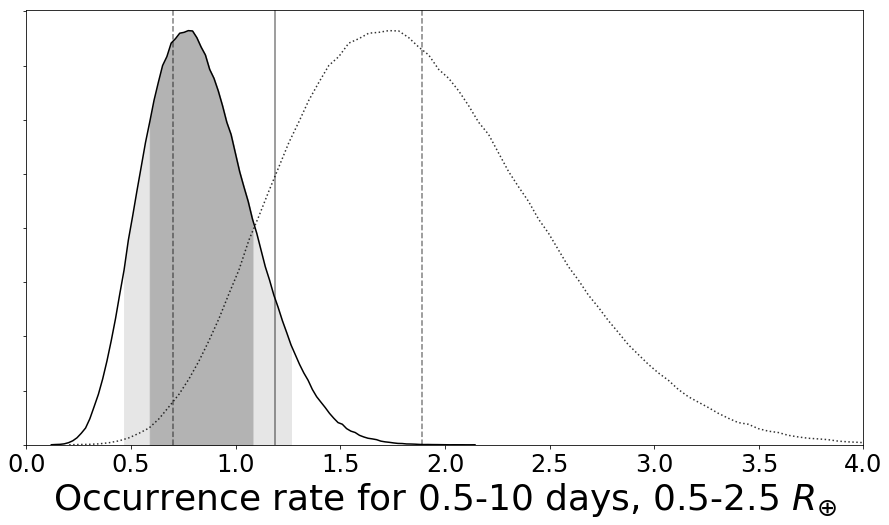

In [7]:
plt.figure(figsize=(15,8));
confDat84 = np.percentile(huDist30d, [16, 50, 84]);
confDat95 = np.percentile(huDist30d, [5, 50, 95]);
hDat = np.histogram(huDist30d, 100);
valX30d = (hDat[1][0:-1] + hDat[1][1:])/2;
valY30d = hDat[0];

plt.plot(valX30d, valY30d, 'k')
#plt.fill_between(valX, valY, color = [.95, .95, .95])
fillIdx95 = (valX30d >= confDat95[0]) & (valX30d <= confDat95[2])
plt.fill_between(valX30d[fillIdx95], valY30d[fillIdx95], color = [.9, .9, .9])
fillIdx84 = (valX30d >= confDat84[0]) & (valX30d <= confDat84[2])
plt.fill_between(valX30d[fillIdx84], valY30d[fillIdx84], color = [.7, .7, .7])

hDat = np.histogram(huDist10d, 100);
valX10d = (hDat[1][0:-1] + hDat[1][1:])/2;
valY10d = hDat[0];
plt.plot(valX10d, valY30d, 'k:', alpha = 0.8)

yl = plt.ylim();
plt.ylim(0, yl[1])
plt.plot([1.19, 1.19], plt.ylim(), 'k', alpha=0.5)
plt.plot([1.19+.7, 1.19+.7], plt.ylim(), 'k--', alpha=0.5)
plt.plot([1.19-.49, 1.19-.49], plt.ylim(), 'k--', alpha=0.5)

plt.xlim(0,4)
plt.xlabel(r"Occurrence rate for 0.5-10 days, 0.5-2.5 $R_{\oplus}$" , fontSize = 36);
plt.gca().set_yticklabels([])
plt.tick_params(labelsize = 24)
plt.savefig("huDist_shaded_uncertainty.pdf",bbox_inches='tight')
